In [2]:
import numpy as np
import scipy.io as sio
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LSTM
import pywt
from xgboost import XGBClassifier

# Load the data
file_path = 'C:\\Users\\UC\\Documents\\NeuMa\\22117124\\new.mat'
new = sio.loadmat(file_path)
Label = new['label_list'].flatten()
EEG = new['EEG']

# Feature extraction for ML
def extract_ml_features(data):
    features = []
    for i in range(data.shape[2]):  # Iterate over samples
        sample = data[:, :, i]
        sample_features = []
        for j in range(data.shape[0]):  # Iterate over channels
            channel_data = sample[j, :]
            # Statistical features
            mean = np.mean(channel_data)
            var = np.var(channel_data)
            skewness = skew(channel_data)
            kurt = kurtosis(channel_data)
            # Frequency domain features using Welch's method
            freqs, psd = welch(channel_data)
            psd_mean = np.mean(psd)
            psd_std = np.std(psd)
            # Combine all features
            sample_features.extend([mean, var, skewness, kurt, psd_mean, psd_std])
        features.append(sample_features)
    return np.array(features)

# Wavelet transform features
def extract_wavelet_features(data):
    features = []
    for i in range(data.shape[2]):  # Iterate over samples
        sample = data[:, :, i]
        sample_features = []
        for j in range(data.shape[0]):  # Iterate over channels
            channel_data = sample[j, :]
            coeffs = pywt.wavedec(channel_data, 'db4', level=4)
            for coeff in coeffs:
                sample_features.extend([np.mean(coeff), np.std(coeff)])
        features.append(sample_features)
    return np.array(features)

ml_features = extract_ml_features(EEG)
wavelet_features = extract_wavelet_features(EEG)
ml_features = np.concatenate((ml_features, wavelet_features), axis=1)

# Feature extraction for DL using CNN and LSTM
input_shape = (EEG.shape[0], EEG.shape[1], 1)

input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(pool2)

# Reshape for LSTM layer
reshape_layer = Reshape((flatten.shape[1], 1))(flatten)
lstm_layer = LSTM(64)(reshape_layer)
dense1 = Dense(128, activation='relu')(lstm_layer)
output_layer = Dense(64, activation='relu')(dense1)  # Output for feature extraction

cnn_rnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_rnn_model.compile(optimizer='adam', loss='mse')

# Reshape data for CNN input
data_cnn = EEG.reshape(EEG.shape[2], EEG.shape[0], EEG.shape[1], 1)

cnn_rnn_features = cnn_rnn_model.predict(data_cnn)

# Combine ML and DL features
combined_features = np.concatenate((ml_features, cnn_rnn_features), axis=1)

# Handle imbalanced data using SMOTE
smote = SMOTE()
combined_features_resampled, labels_resampled = smote.fit_resample(combined_features, Label)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features_resampled, labels_resampled, test_size=0.2, random_state=42)

# Best parameters found by Optuna (replace with actual best parameters if different)
best_params = {'rf_n_estimators': 265, 'gb_n_estimators': 89, 'xgb_n_estimators': 300}

rf_clf = RandomForestClassifier(n_estimators=best_params['rf_n_estimators'])
gb_clf = GradientBoostingClassifier(n_estimators=best_params['gb_n_estimators'])
xgb_clf = XGBClassifier(n_estimators=best_params['xgb_n_estimators'])

stacking_clf = StackingClassifier(estimators=[
    ('rf', rf_clf), 
    ('gb', gb_clf),
    ('xgb', xgb_clf)
], final_estimator=RandomForestClassifier(n_estimators=100))

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_proba_ml = stacking_clf.predict_proba(X_test)[:, 1]
y_pred_ml = (y_pred_proba_ml > 0.5).astype(int)
print("ML Model (Stacking) Classification Report:")
print(classification_report(y_test, y_pred_ml))


346/346 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step
ML Model (Stacking) Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      1409
           1       0.73      0.65      0.69      1340

    accuracy                           0.71      2749
   macro avg       0.72      0.71      0.71      2749
weighted avg       0.71      0.71      0.71      2749



Epoch 1/50


C:\Users\UC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5341 - loss: 2.2951 - val_accuracy: 0.6028 - val_loss: 0.6596
Epoch 2/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6706 - loss: 0.6017 - val_accuracy: 0.6494 - val_loss: 0.6256
Epoch 3/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7300 - loss: 0.5247 - val_accuracy: 0.6518 - val_loss: 0.6354
Epoch 4/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7646 - loss: 0.4719 - val_accuracy: 0.6479 - val_loss: 0.6749
Epoch 5/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7997 - loss: 0.4281 - val_accuracy: 0.6751 - val_loss: 0.6694
Epoch 6/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8241 - loss: 0.3737 - val_accuracy: 0.6853 - val_loss: 0.6799
Epoch 7/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8375 - loss: 0.3465 - val_accuracy: 0.6901 - val_loss: 0.7209
Epoch 8/50
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8615 - loss: 0.3171 - val_accuracy: 0.694

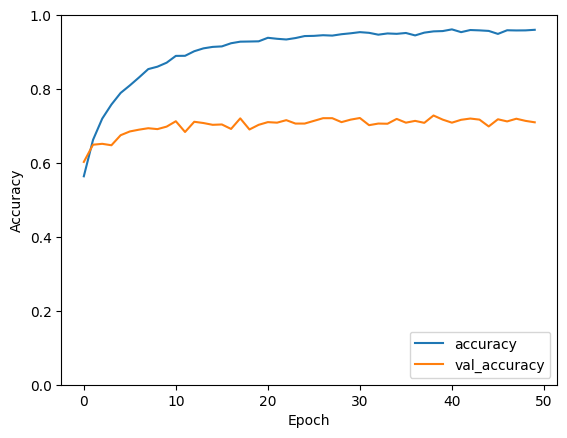

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7249 - loss: 1.4041
Test accuracy: 0.7134


ValueError: The layer sequential_2 has never been called and thus has no defined input.

In [5]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load data
file_path = 'C:\\Users\\UC\\Documents\\NeuMa\\22117124\\new.mat'
new = sio.loadmat(file_path)
ET = new['ET']
Label_array_ET = new['label_list']

# Create an empty list to store the images
image_list = []

# Loop through each sample
for sample_idx in range(ET.shape[2]):
    # Extract X and Y coordinates for both eyes
    x_left, y_left, _, x_right, y_right, _ = ET[:, :, sample_idx]

    # Create a blank canvas (64x64) for the gaze plot
    gaze_plot = np.zeros((64, 64, 3), dtype=np.uint8)  # Initialize as black image

    # Scale the coordinates to match the canvas size
    scaled_x_left = (x_left * 64).astype(int)
    scaled_y_left = (y_left * 64).astype(int)
    scaled_x_right = (x_right * 64).astype(int)
    scaled_y_right = (y_right * 64).astype(int)

    # Set gaze points as white pixels on the canvas
    for i in range(120):
        if 0 <= scaled_x_left[i] < 64 and 0 <= scaled_y_left[i] < 64:
            gaze_plot[scaled_y_left[i], scaled_x_left[i]] = [255, 255, 255]  # White color
        if 0 <= scaled_x_right[i] < 64 and 0 <= scaled_y_right[i] < 64:
            gaze_plot[scaled_y_right[i], scaled_x_right[i]] = [255, 255, 255]  # White color

    # Append the gaze plot to the image list
    image_list.append(gaze_plot)

# Convert the list of images to a NumPy array
image_array = np.array(image_list)

# Reshape images to have a single channel (grayscale)
image_array = np.expand_dims(image_array, axis=-1)

# Balance the data using SMOTE
smote = SMOTE(random_state=42)
image_array_resampled, Label_array_ET_resampled = smote.fit_resample(image_array.reshape(-1, 64*64*3), Label_array_ET)

# Reshape the resampled data back to the original shape
image_array_resampled = image_array_resampled.reshape(-1, 64, 64, 3)

# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(image_array_resampled, Label_array_ET_resampled, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Define LeNet-5 architecture
model = models.Sequential([
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

# Visualize training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Extract features for late fusion
feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-2].output)
et_features = feature_extractor.predict(image_array_resampled)

# Train final model on ET features (Example using RandomForestClassifier)
rf_et = RandomForestClassifier(n_estimators=100)
rf_et.fit(et_features, Label_array_ET_resampled)
y_pred_proba_et = rf_et.predict_proba(et_features)[:, 1]
y_pred_et = (y_pred_proba_et > 0.5).astype(int)
print("ET Model (Random Forest) Classification Report:")
print(classification_report(Label_array_ET_resampled, y_pred_et))


In [10]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LSTM
import matplotlib.pyplot as plt

# Load the data
file_path = 'C:\\Users\\UC\\Documents\\NeuMa\\22117124\\new.mat'
new = sio.loadmat(file_path)
Label = new['label_list'].flatten()
EEG = new['EEG']
ET = new['ET']
from sklearn.utils import resample

from sklearn.utils import resample

# Determine the number of samples to use
num_samples = min(EEG.shape[0], ET.shape[0])

# Resample EEG and ET data to have the same number of samples
EEG_resampled = resample(EEG, n_samples=num_samples, random_state=42)
ET_resampled = resample(ET, n_samples=num_samples, random_state=42)

# Now both EEG_resampled and ET_resampled have the same number of samples


# Split the resampled data into training and test sets
X_train_eeg, X_test_eeg, y_train, y_test = train_test_split(EEG_resampled, Label, test_size=0.2, random_state=42)
X_train_et, X_test_et, y_train, y_test = train_test_split(ET_resampled, Label, test_size=0.2, random_state=42)

# Define EEG feature extraction model
input_shape_eeg = (EEG.shape[0], EEG.shape[1], 1)
input_layer_eeg = Input(shape=input_shape_eeg)
conv1_eeg = Conv2D(32, (3, 3), activation='relu')(input_layer_eeg)
pool1_eeg = MaxPooling2D((2, 2))(conv1_eeg)
conv2_eeg = Conv2D(64, (3, 3), activation='relu')(pool1_eeg)
pool2_eeg = MaxPooling2D((2, 2))(conv2_eeg)
flatten_eeg = Flatten()(pool2_eeg)
dense1_eeg = Dense(128, activation='relu')(flatten_eeg)
output_layer_eeg = Dense(64, activation='relu')(dense1_eeg)
eeg_feature_extractor = Model(inputs=input_layer_eeg, outputs=output_layer_eeg)
eeg_feature_extractor.compile(optimizer='adam', loss='mse')

# Train EEG feature extraction model
eeg_feature_extractor.fit(X_train_eeg, y_train, epochs=10, validation_split=0.2)

# Define ET feature extraction model
input_shape_et = (ET.shape[0], ET.shape[1], 1)
input_layer_et = Input(shape=input_shape_et)
conv1_et = Conv2D(32, (3, 3), activation='relu')(input_layer_et)
pool1_et = MaxPooling2D((2, 2))(conv1_et)
conv2_et = Conv2D(64, (3, 3), activation='relu')(pool1_et)
pool2_et = MaxPooling2D((2, 2))(conv2_et)
flatten_et = Flatten()(pool2_et)
dense1_et = Dense(128, activation='relu')(flatten_et)
output_layer_et = Dense(64, activation='relu')(dense1_et)
et_feature_extractor = Model(inputs=input_layer_et, outputs=output_layer_et)
et_feature_extractor.compile(optimizer='adam', loss='mse')

# Train ET feature extraction model
et_feature_extractor.fit(X_train_et, y_train, epochs=10, validation_split=0.2)

# Extract features from EEG and ET models
eeg_features = eeg_feature_extractor.predict(X_test_eeg)
et_features = et_feature_extractor.predict(X_test_et)

# Combine features
combined_features = np.concatenate((eeg_features, et_features), axis=1)

# Handle imbalanced data using SMOTE
smote = SMOTE()
combined_features_resampled, labels_resampled = smote.fit_resample(combined_features, y_test)

# Train the final classification model using combined features
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(combined_features_resampled, labels_resampled)

# Evaluate the model on the test set
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))


ValueError: Found input variables with inconsistent numbers of samples: [6, 11068]

In [7]:
# Extract features for late fusion
feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-2].output)
et_features = feature_extractor.predict(image_array_resampled)


ValueError: The layer sequential_2 has never been called and thus has no defined input.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Weighted averaging
combined_proba = 0.5 * y_pred_proba_ml + 0.5 * y_pred_proba_et
y_pred_combined_avg = (combined_proba > 0.5).astype(int)
print("Combined Model (Weighted Averaging) Classification Report:")
print(classification_report(y_test, y_pred_combined_avg))

# Logistic Regression for late fusion
lr_fusion = LogisticRegression()
X_combined = np.vstack((y_pred_proba_ml, y_pred_proba_et)).T
lr_fusion.fit(X_combined, y_test)
y_pred_combined_lr = lr_fusion.predict(X_combined)
print("Combined Model (Logistic Regression) Classification Report:")
print(classification_report(y_test, y_pred_combined_lr))

# Stacking for late fusion
stacking_fusion = StackingClassifier(estimators=[
    ('ml_model', rf_clf), 
    ('et_model', rf_et)
], final_estimator=LogisticRegression())

stacking_fusion.fit(X_combined, y_test)
y_pred_combined_stack = stacking_fusion.predict(X_combined)
print("Combined Model (Stacking) Classification Report:")
print(classification_report(y_test, y_pred_combined_stack))

# Voting classifier for late fusion
voting_fusion = VotingClassifier(estimators=[
    ('ml_model', rf_clf), 
    ('et_model', rf_et)
], voting='soft')

voting_fusion.fit(X_combined, y_test)
y_pred_combined_vote = voting_fusion.predict(X_combined)
print("Combined Model (Voting) Classification Report:")
print(classification_report(y_test, y_pred_combined_vote))


NameError: name 'y_pred_proba_et' is not defined